### Dataset Link


#### Yahoo Finance https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?select=symbols_valid_meta.csv

#### NEWS API https://newsapi.org/docs/client-libraries/python

### Import necessary packages for the project

In [1]:
import os

import time
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import dask.dataframe as dd
from dask import delayed, compute

from IPython.display import display, HTML

from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from dask.distributed import LocalCluster

### Set the working directory and dataset path

In [2]:
working_directory = '/home/rajagopalmohanraj.n/HPC/final_project/'
datasets = working_directory + 'datasets/'

In [3]:
def get_csv():
    
    """
    Read all CSV files from the 'stocks' folder, add a Stock Symbol column,
    and return a Dask DataFrame.
    """
    
    # Reading all CSV files and adding Stock Symbol
    stock_df = dd.read_csv(
        f'{datasets}stocks/*.csv',
        blocksize='16MB',
        dtype={
            'Date': 'str',
            'Open': 'float64',
            'High': 'float64',
            'Low': 'float64',
            'Close': 'float64',
            'Volume': 'float64'
        },
        include_path_column='source_file'  # Adds filename as a column
    )
    
    # Extracting stock symbol from filename
    stock_df['Symbol'] = stock_df['source_file'].map_partitions(
        lambda x: x.str.extract(r'([A-Z]+)\.csv$')[0]
    )
    
    # Dropping the source_file column
    stock_df = stock_df.drop('source_file', axis=1)
    stock_df = stock_df.repartition(npartitions=200)
    stock_df = stock_df.persist()
    return stock_df

In [4]:
def cluster_comparision_for_get_csv():
    
    """
    Compare the execution time of get_csv() function using LocalCluster and SLURMCluster.
    Returns a dictionary with timing results.
    """
    
    timing_results = {'LocalCluster': 0, 'SLURMCluster': 0}
    
    # Ignoring warnings related to cluster running ports
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Local Cluster
        with LocalCluster(n_workers=8, threads_per_worker=4, memory_limit='16GB', processes=False) as cluster:
            with Client(cluster) as client:
                display(HTML(f"<a href='{client.dashboard_link}'>Dask Dashboard</a>"))
                print(f"Dashboard link: {client.dashboard_link}")
                print(f"Cluster status: {client.status}")
                
                start_time = time.time()
                df = get_csv()
                rows, columns = df.shape[0].compute(), df.shape[1]
                print(f"The size of the df is : {rows}, {columns}")
                timing_results['LocalCluster'] = time.time() - start_time
                
                client.close()
                cluster.close()
            
        # SLURM Cluster
        with SLURMCluster(cores=8, processes=4, memory="16GB", queue="short", walltime="01:00:00") as cluster:
            cluster.adapt(minimum=5, maximum=10)
            with Client(cluster) as client:
                display(HTML(f"<a href='{client.dashboard_link}'>Dask Dashboard</a>"))
                print(f"Dashboard link: {client.dashboard_link}")
                print(f"Cluster status: {client.status}")
                
                start_time = time.time()
                df = get_csv()
                rows, columns = df.shape[0].compute(), df.shape[1]
                print(f"The size of the df is : {rows}, {columns}")
                timing_results['SLURMCluster'] = time.time() - start_time
                
                client.close()
                cluster.close()

    return timing_results

In [5]:
def plot_comparison(results):
    
    """
    Plot a bar chart comparing the execution times of LocalCluster and SLURMCluster.
    """
    
    plt.figure(figsize=(8, 5))
    plt.bar(results.keys(), results.values(), color=['blue', 'orange'])
    plt.ylabel('Execution Time (seconds)')
    plt.title('Data Loading Time: LocalCluster vs SLURMCluster')
    
    # Adding Time labels on bars
    for i, (cluster, time) in enumerate(results.items()):
        plt.text(i, time + 0.2, f'{time:.2f}', ha='center')
    
    plt.show()

In [6]:
results = cluster_comparision_for_get_csv()
results

Dashboard link: http://10.99.253.33:8787/status
Cluster status: running
The size of the df is : 24197442, 8


Dashboard link: http://10.99.253.33:8787/status
Cluster status: running
The size of the df is : 24197442, 8


2024-12-01 22:40:26,508 - distributed.deploy.adaptive_core - INFO - Adaptive stop


{'LocalCluster': 328.96377873420715, 'SLURMCluster': 78.71846580505371}

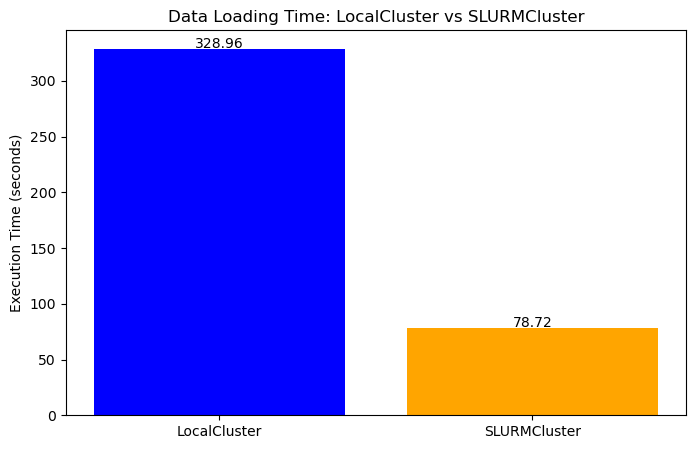

In [7]:
plot_comparison(results)